In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# Parameter Sweeps

Our parameter sweeps were executed on a high performance computing cluster and are not well suited for reproduction on a personal computer. Nevertheless, we have provided scripts to directly reproduce the simulations themselves, but please note that *executing these scripts would take a very long time to complete.* Additionally, the outputs from each of our parameter sweeps are provided in `data/simulations/parameter_sweeps`. In the sections below, we provide an overview of how our parameter sweeps were constructed and executed. We then walk the user through accessing and visualizing the output from each of our completed data sets.

### Constructing a parameter sweep

To see how our parameter sweeps are constructed or to attempt to run one on your own computing cluster, interested users may refer to the `build_sweep.py` script in the `gram/scripts` directory. This script serves as the basis for constructing each of our parameter sweeps. For example, a sweep of the linear model would be generated by executing `python build_sweep.py -m linear -N 5000 -n 2500` at the command line. The `-m` flag denotes the model of interest, e.g. `linear`, `twostate`, or `hill`. The `-N` flag denotes the number of simulated trajectories per parameter set, and the `-n` flag denotes the number of unique parameter sets. Many more optional arguments are provided via the `gram.execution.arguments` module. Upon execution, the `build_sweep.py` script creates a "sweep directory" containing all of the contents necessary to execute the parameter sweep. The sweep directory is named using a combination of the model type and the current date and time, resulting in something similiar to `MODEL_YYMMDD_hhmmss`. For simplicity we have renamed the sweep directories in our completed results.

### Sweep directory file structure

A schematic of the sweep directory file structure is provided below. The top level contains a serialized `gram.sweeps.Sweep` instance under the filename `./batch.pkl`. This instance serves as the focal point for constructing and executing the parameter sweep, then aggregating its results. The sweep directory also contains a `./simulations/` subdirectory containing a serialized `ConditionSimulation` instance for each of the $n$ parameter sets to be simulated. Upon submission to the computing cluster, these simulation instances will be deseralized and executed in parallel. The `./batches/` subdirectory contains text files used to manage the paralellization of job submissions, and the `./log/` subdirectory provides log files.

### Running a parameter sweep

The sweep directory contains a `./scripts` subdirectory that includes a pair of shell scripts. We used the `./scripts/submit.sh` script to submit these jobs to our computing cluster. We have also included a `./scripts/run.sh` script that will execute the entire parameter sweep on a personal computer. **Please note that executing this script will take a very long time.**

### Aggregating results from a parameter sweep

The results are aggregated from each simulation using the deserialized `batch.pkl` object, which is accessed via the `Sweep.load` method. The results are then aggregated by executing `.aggregate()`, and may optionally be saved to `./data.hdf` in the top level of the sweep directory by executing `.save()`. Any saved results are loaded by default.

In [2]:
from gram.sweep.sweep import Sweep

sweep_path = '../data/simulations/parameter_sweeps/linear/'
sweep = Sweep.load(sweep_path)  # loads deserialized gram.Sweep object
#sweep.aggregate()               # aggregates results from each ConditionSimulation instance
#sweep.save()                    # saves aggregated results to ./data.hdf

### Accessing simulations within a sweep

Given a `Sweep` instance, individual simulations can be accessed by simple indexing.

In [13]:
simulation = sweep[0]

### Visualizing the results from a parameter sweep

We have provided three means of visually summarizing the results of a parameter sweep. These methods provide the user with a high level view of individual simulation outcomes such as error frequency, protein overexpression, or the change in either quantity when metabolic conditions are changed. The approaches are:

  ##### 1. Multidimensional Projection
Individual simulation outcomes are projected onto 2D planes spanned by paired components of the sampled parameter space. All pairs are visualized, with the projections interpolated onto a continuous surface. This representation helps depict macroscopic trends in simulation outcome as a function of each of the model's key parameters. However, the projection from a high dimensional space onto a 2D grid leads to a very noisy depiction of parameter dependence. Furthermore, this visualization strategy can be cumbersome to interpret.

To create a multidimensional projection, we can initialize the figure using the `Sweep.build_figure` method, which returns a `SweepFigure` instance. The `condition` argument defines the metabolic conditions of interest using a shorthand notation:

    * 'normal': Normal metabolism
    * 'diabetic': Reduced energy metabolism
    * 'minute': Reduced protein synthesis
    * 'carbon_limited': Reduced RNA/protein synthesis

The `mode` argument defines the outcome of interest (see the definitions in our manuscript). Options are:

    * 'threshold_error': Frequency of developmental errors 
    * 'error': Average protein overexpression

The `relative` argument determines whether or not the simulation outcomes are expressed as differential values relative to normal metabolic conditions. In other words, if `condition='diabetic'` and `relative=False`, error frequencies under conditions of reduced energy metabolism are displayed directly. If `relative=True`, the difference in error frequency between normal conditions and conditions of reduced energy metabolism are shown.

We then use the `SweepFigure.render` method to visualize the multidimensional projection, subject to a number of formatting parameters.

### Fig. S1B

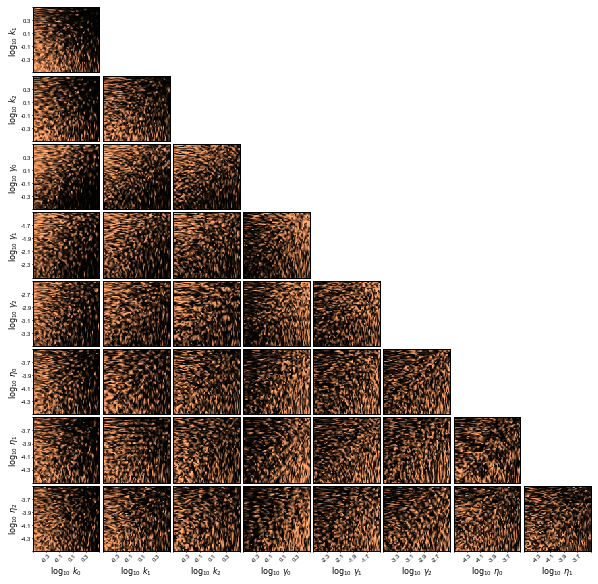

In [3]:
# Fig. S1B: Multidimensional projection of error frequencies under normal metabolic conditions
fig_S1B = sweep.build_figure(condition='normal', mode='threshold_error', relative=False)
fig_kwargs = dict(figsize=(10, 10))
heatmap_kwargs = dict(cmap=plt.cm.copper_r, bad='r', vmin=0, vmax=1, rasterized=True)
fig_S1B.render(density=100, labelsize=6, fig_kwargs=fig_kwargs, heatmap_kwargs=heatmap_kwargs, include_labels=True)

  ##### 2. 1D Histogram

The distribution of individual simulation outcomes are summarized by a simple histogram. This approach conveys nothing about the underlying parameter dependence, but helps provide a quick overview of global trends.

We can compile a `SweepHistogram` instance using the `Sweep.build_histogram` method. The method accepts the same arguments as `Sweep.build_figure`, as described above. We then render the histograms by executing `SweepHistogram.render`.

### Figs. S2AB, S3CD, and S4AB

Text(0.5,0,'Difference in percent overexpression\nwhen protein synthesis is low')

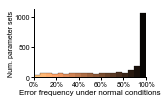

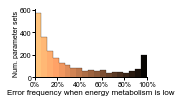

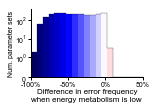

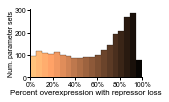

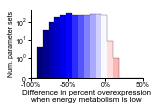

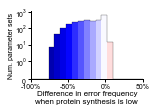

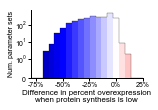

In [4]:
# Fig. S2A, left panel: Histogram of error frequencies under normal metabolic conditions
fig_S2A_left = sweep.build_histogram(condition='normal', relative=False, mode='threshold_error')
fig_S2A_left.render(xlim=(0, 1), bins=20, log=False, cmap=plt.cm.copper_r, vlim=(0, 1))
fig_S2A_left.ax.set_xlabel('Error frequency under normal conditions')

# Fig. S2A, right panel: Histogram of error frequencies when energy metabolism is reduced
fig_S2A_right = sweep.build_histogram(condition='diabetic', relative=False, mode='threshold_error')
fig_S2A_right.render(xlim=(0, 1), bins=20, log=False, cmap=plt.cm.copper_r, vlim=(0, 1))
fig_S2A_right.ax.set_xlabel('Error frequency when energy metabolism is low')

# Fig. S2B: Histogram of change in error frequencies when energy metabolism is reduced
fig_S2B = sweep.build_histogram(condition='diabetic', relative=True, mode='threshold_error')
fig_S2B.render(xlim=(-1, 0.5), bins=20)
fig_S2B.ax.set_xlabel('Difference in error frequency\nwhen energy metabolism is low')

# Figure S3C: Percent overexpression under normal conditions
fig_S3C = sweep.build_histogram(condition='normal', relative=False, mode='error')
fig_S3C.render(xlim=(0., 1.), bins=20, cmap=plt.cm.copper_r, log=False, vlim=(0, 1))
fig_S3C.ax.set_xlabel('Percent overexpression with repressor loss')

# Figure S3D: Difference in percent overexpression when metabolism is low
fig_S3D = sweep.build_histogram(condition='diabetic', relative=True, mode='error')
fig_S3D.render(xlim=(-1., .5), bins=20, cmap=plt.cm.seismic, log=True, vlim=(-1, 1))
fig_S3D.ax.set_xlabel('Difference in percent overexpression\nwhen energy metabolism is low')

# Figure S4A: Difference in error frequency when protein synthesis is low
fig_S4A = sweep.build_histogram(condition='minute', relative=True, mode='threshold_error')
fig_S4A.render(xlim=(-1, 0.5), bins=20)
fig_S4A.ax.set_xlabel('Difference in error frequency\nwhen protein synthesis is low')

# Figure S4B: Difference in percent overexpression when metabolism is low
fig_S4B = sweep.build_histogram(condition='minute', relative=True, mode='error')
fig_S4B.render(xlim=(-.8, 0.25), bins=20)
fig_S4B.ax.set_xlabel('Difference in percent overexpression\nwhen protein synthesis is low')

  ##### 3. Line Projection

Individual simulation outcomes are plotted as a function of where the success threshold is set. This approach is similar to the 1D histogram, but helps show whether the global trend depends upon where the success threshold is set.

Line projections are compiled using `Sweep.build_lines` which returns a `SweepLines` object. The figure is then rendered via the `SweepLines.render` method.

### Figs. S1C, S2C, and S4C

Text(0,0.5,'Decrease in error frequency')

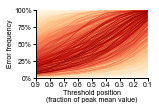

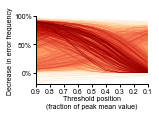

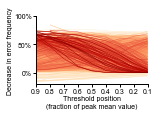

In [5]:
# Figure S1C: Error frequency as a function of threshold position under normal growth conditions
fig_S1C = sweep.build_lines(condition='normal', mode='threshold_error', relative=False)
fig_S1C.render(vlim=(0., 1.), ylim=(0., 1.))

# Figure S2C: Decrease in error frequency as a function of threshold position when energy metabolism is low
fig_S2C = sweep.build_lines(condition='diabetic', mode='threshold_error', relative=True)
fig_S2C.render(vlim=(0., 1.2), ylim=(-.2, 1.))
fig_S2C.ax.set_ylabel('Decrease in error frequency')

# Figure S4C: Decrease in error frequency as a function of threshold position when protein synthesis is low
fig_S4C = sweep.build_lines(condition='minute', mode='threshold_error', relative=True)
fig_S4C.render(vlim=(0., 1.2), ylim=(-.2, 1.))
fig_S4C.ax.set_ylabel('Decrease in error frequency')

# Additional Models

## Linear model with basal stimulus (Figs. S2D and S4D)

In [6]:
from gram.sweep.sweep import Sweep

sweep = Sweep.load('../data/simulations/parameter_sweeps/basal_stimulus/')

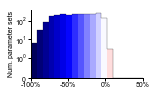

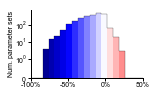

In [7]:
fig_S2D = sweep.build_histogram(condition='diabetic', relative=True, mode='threshold_error')
fig_S2D.render(xlim=(-1., 0.5), bins=20)

fig_S4D = sweep.build_histogram(condition='minute', relative=True, mode='threshold_error')
fig_S4D.render(xlim=(-1., 0.5), bins=20)

## Linear model with extended stimulus  (Figs. S2E and S4E)

In [8]:
from gram.sweep.sweep import Sweep

sweep = Sweep.load('../data/simulations/parameter_sweeps/scaled_stimulus/')

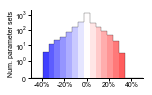

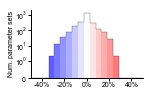

In [9]:
fig_S2E = sweep.build_histogram(condition='diabetic', relative=True, mode='threshold_error')
fig_S2E.render(xlim=(-0.5, 0.5), bins=20)

fig_S2E = sweep.build_histogram(condition='minute', relative=True, mode='threshold_error')
fig_S2E.render(xlim=(-0.5, 0.5), bins=20)

## Two-state transcription model (Figs. S2F and S4F)

In [10]:
from gram.sweep.sweep import Sweep

sweep = Sweep.load('../data/simulations/parameter_sweeps/twostate/')

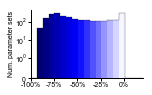

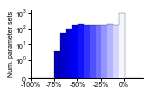

In [11]:
fig_S2F = sweep.build_histogram(condition='diabetic', relative=True, mode='threshold_error')
fig_S2F.render(xlim=(-1., 0.2), bins=20)

fig_S4F = sweep.build_histogram(condition='minute', relative=True, mode='threshold_error')
fig_S4F.render(xlim=(-1., 0.2), bins=20)

## Hill kinetics model

In [12]:
from gram.sweep.sweep import Sweep

sweep = Sweep.load('../data/simulations/parameter_sweeps/hill/')

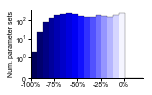

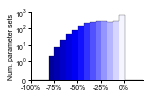

In [13]:
fig_S2G = sweep.build_histogram(condition='diabetic', relative=True, mode='threshold_error')
fig_S2G.render(xlim=(-1., 0.2), bins=20)

fig_S4G = sweep.build_histogram(condition='minute', relative=True, mode='threshold_error')
fig_S4G.render(xlim=(-1., 0.2), bins=20)